# Exploratory Data Analysis
Starbucks Data Set  
Udacity DSND Capstone Project

## Goal
Establish offer types and channels that best stimulate purchases

Steps
- Cluster users to establish segments
- is 0 time the same for all users (start date)

- Train a regression model to predict the following purchases given: customer segment, channels, difficulty, duration, reward

How do I account for users who prefer not to get ads?

In [60]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


## Data Cleaning

### Portfolio dataset

In [17]:
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [18]:
# Separate channels into multiple columns
channels = []
for i in portfolio.channels:
    channels.extend(i)
channels = list(set(channels))

for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in x else 0)

portfolio.drop(columns = 'channels', inplace = True)


In [19]:
#separate offer_type into multiple columns
offers = portfolio.offer_type.value_counts().index

for offer in offers:
    portfolio[offer] = portfolio.offer_type.apply(lambda x: 1 if offer in x else 0)

portfolio.drop(columns = 'offer_type', inplace = True)

In [20]:
portfolio.head(10)

,reward,difficulty,duration,id,mobile,email,social,web,discount,bogo,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,0,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,1,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1,0,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,0,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0,1,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,1,0,0


## Transcript Dataset

In [65]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [66]:
#split 'value' column

transcript['value_label'] = transcript.value.apply(lambda x: [*x][0])
transcript['value'] = transcript.value.apply(lambda x: list(x.values())[0])

#convert transaction time into days
transcript.time = transcript.time/24

transcript.head()

,person,event,value,time,value_label
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0.0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,offer id


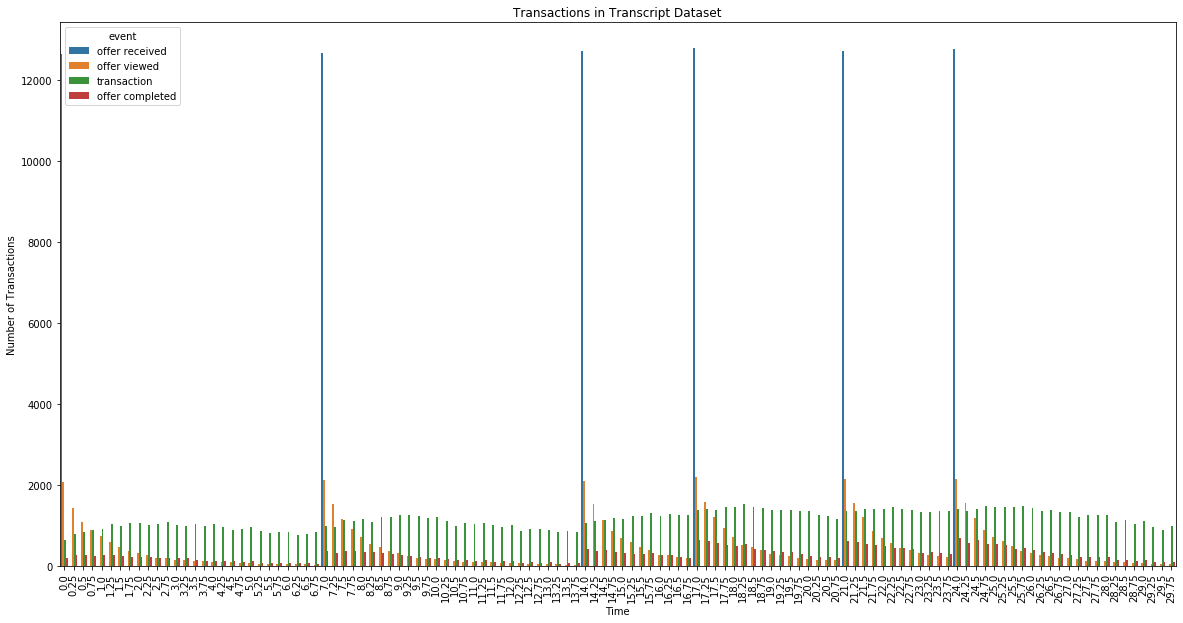

In [67]:
#what's the distribution of the time value
plt.figure(figsize=(20,10))
sns.countplot(transcript.time, hue = transcript.event)
plt.xticks(rotation=90)
plt.title('Transactions in Transcript Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

In [68]:
transcript[transcript.event == 'offer received'].time.value_counts()
##only 6 times that offers are received 

17.0    12778
24.0    12765
14.0    12711
21.0    12704
7.0     12669
0.0     12650
Name: time, dtype: int64

In [69]:
# are offers sent only at the same time? --NO
transcript[(transcript.event == 'offer received') & (transcript.value == '9b98b8c7a33c4b65b9aebfe6a799e6d9')].time.value_counts()

24.0    1326
7.0     1296
14.0    1275
17.0    1274
21.0    1261
0.0     1245
Name: time, dtype: int64

In [146]:
# separate transactions out from offers table. Then establish of transactions were 'influenced' or not
transactions = transcript[transcript.event == 'transaction'][['person','value','time']]
offers = transcript[transcript.event != 'transaction']

transactions.head()

,person,value,time
12654,02c083884c7d45b39cc68e1314fec56c,0.83,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,0.0
12659,54890f68699049c2a04d415abc25e717,13.23,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,0.0


In [147]:
#pivot for each person and subsequent offer
offers = offers.pivot_table(values = 'time',index = ['person','value'], columns = 'event').reset_index()
offers.columns = ['person','offer','time_completed', 'time_received','time_viewed']
offers.head()

,person,offer,time_completed,time_received,time_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.00,24.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.5
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0,8.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.25,17.0,19.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,22.00,21.0,22.5


In [148]:
#what is the completeness of the data? 
offers[offers.offer == '3f207df678b143eea3cee63160fa8bed']

,person,offer,time_completed,time_received,time_viewed
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.50
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.25
20,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.50
27,004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed,NaN,7.0,NaN
38,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,NaN,21.0,22.00
...,...,...,...,...,...
63224,ffc77312ccda49fca19506f1cdf44923,3f207df678b143eea3cee63160fa8bed,NaN,21.0,NaN
63228,ffc8a38e0972421785b00f80c92c8085,3f207df678b143eea3cee63160fa8bed,NaN,0.0,NaN
63235,ffd810f301ad42d6bfe98c4ba6ee4125,3f207df678b143eea3cee63160fa8bed,NaN,14.0,14.25
63264,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,NaN,15.5,19.25


In [149]:
#merge offers dataframe with portfolio to establish timelines of influence
offers = offers.merge(portfolio, how = 'left',left_on='offer', right_on= 'id').drop(columns='id')

offers['end_of_influence'] = offers.apply(lambda x: min([x.time_received+x.duration, x.time_completed]),axis = 1)
offers.head()

,person,offer,time_completed,time_received,time_viewed,reward,difficulty,duration,web,social,email,mobile,bogo,discount,informational,end_of_influence
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.00,24.0,NaN,2,10,7,1,0,1,1,0,1,0,24.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,14.0,15.5,0,0,4,1,0,1,1,0,0,1,18.00
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0,8.0,0,0,3,0,1,1,1,0,0,1,10.00
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.25,17.0,19.0,5,5,5,1,1,1,1,1,0,0,17.25
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,22.00,21.0,22.5,2,10,10,1,1,1,1,0,1,0,22.00


In [150]:
# establish if transactions were 'influenced' or not, and by which offer
def influenced_check (trns_row, offers=offers):
    '''
    Checks if each transaction is influenced by an offer or not
    '''
    # trns_row: person, value, time
    
    # filter offers table for person
    person_offers = offers[offers.person == trns_row.person]

    #cycle through offers
    for _, offer_row in person_offers.iterrows():
        
        #if transaction was within span of influence
        #time viewed is not nan, transaction time is > time viewed, and trs time is < end of influence
        if (offer_row.time_viewed != np.nan) & (trns_row.time >=offer_row.time_viewed) & (trns_row.time <=offer_row.end_of_influence):
            return [True, offer_row.offer ]

    #if transaction was outside of any influence span
    return [False, np.nan]


In [218]:
#loop through all transactions to test if it was influenced. TAKES LONG TIME
tmp = transactions.apply(lambda x: influenced_check(x,offers), axis=1).apply(pd.Series)
tmp.columns = ['influenced','offer']
transactions = pd.concat([transactions,tmp],axis=1)
transactions['day'] = np.floor(transactions.time)
transactions.offer.fillna(0,inplace = True)

transactions.head()

,person,value,time,influenced,offer,day
12654,02c083884c7d45b39cc68e1314fec56c,0.83,0.0,True,ae264e3637204a6fb9bb56bc8210ddfd,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,0.0,True,2906b810c7d4411798c6938adc9daaa5,0.0
12659,54890f68699049c2a04d415abc25e717,13.23,0.0,False,0,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,0.0,False,0,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,0.0,False,0,0.0


In [285]:

def avg_daily_value (transactions):
    
    person_offer_spend = pd.DataFrame(columns = ['person','offer','avg_daily_spend', 'total_spend', 'days'])

    for person in set(transactions.person):
        
        #subset dataframe for each person
        person_trns = transactions[transactions.person==person]

        #create time period indexed column
        person_trns.sort_values(by = 'time',inplace=True)
        person_trns['time_per'] = (person_trns['offer'] != person_trns['offer'].shift(1)).cumsum()

        # instantiate previous max day indicator
        prev_max = 0
        
        # loop through time periods
        for i in set(person_trns['time_per']):

            # find the max day in this time period
            # limitation: for the last time period, it will not assume the 29th day (last day) - more logic is required
                # the case of an offer ending but no influced transactions following is missed with this. Can be added in future version
            cur_max = person_trns[person_trns.time_per==i].day.max()

            # gather variables to append to resultant dataset
            offer = person_trns[person_trns.time_per==i].iloc[0].offer
            total_spend = person_trns[person_trns.time_per==i].value.sum()
            days = cur_max-prev_max + 1
            avg_daily = total_spend/days

            # establish row and append to resultant dataset
            row = {'person':person, 'offer':offer, 'avg_daily_spend': avg_daily, 'total_spend':total_spend, 'days':days}
            person_offer_spend=person_offer_spend.append(row, ignore_index=True)

            #iterate prev_max counter for next cycle
            prev_max = cur_max


    return person_offer_spend

In [286]:
trns_avg_daily = avg_daily_value(transactions)
trns_avg_daily.head()

,person,offer,avg_daily_spend,total_spend,days
0,565c54e335184cb2a0cc563b6f9af82b,0,0.757500,9.09,12.0
1,565c54e335184cb2a0cc563b6f9af82b,f19421c1d4aa40978ebb69ca19b0e20d,0.250909,2.76,11.0
2,565c54e335184cb2a0cc563b6f9af82b,0,10.493333,62.96,6.0
3,3c4fd3642bbb47b285cec7816104649c,0,0.400714,11.22,28.0
4,a27c674f9562416fa55c927bd678ebe1,ae264e3637204a6fb9bb56bc8210ddfd,1.124286,7.87,7.0


In [293]:
no_influence = trns_avg_daily[trns_avg_daily.offer==0].groupby(by = 'person',as_index=False).sum()
no_influence['avg_daily_spend']=no_influence.total_spend/no_influence.days

no_influence.drop(columns = ['total_spend','days'],inplace = True) 
no_influence.columns = ['person','no_influence_avg_daily_spend']
no_influence.head()

,person,no_influence_avg_daily_spend
0,0009655768c64bdeb2e877511632db8f,7.451538
1,00116118485d4dfda04fdbaba9a87b5c,0.053846
2,0011e0d4e6b944f998e987f904e8c1e5,4.548000
3,0020c2b971eb4e9188eac86d93036a77,9.032222
4,0020ccbbb6d84e358d3414a3ff76cffd,5.868000


In [292]:
#do we have non offer influenced transactions for all people? --NO
persons_offer_trns_only = list(set(transactions.person) -set(no_influence.person))
len(persons_offer_trns_only)

#we will ignore these individuals in the modeling stage

793

In [295]:
#merge offer impact with no offer transaction behavior
offer_impact = trns_avg_daily[trns_avg_daily.offer != 0][['person','offer','avg_daily_spend']]
offer_impact.columns = ['person','offer','offer_daily_spend']
offer_impact = offer_impact.merge(no_influence, how='inner',left_on = 'person',right_on = 'person')
offer_impact['lift'] = offer_impact.offer_daily_spend/offer_impact.no_influence_avg_daily_spend
offer_impact.head()


,person,offer,offer_daily_spend,no_influence_avg_daily_spend,lift
0,565c54e335184cb2a0cc563b6f9af82b,f19421c1d4aa40978ebb69ca19b0e20d,0.250909,4.002778,0.062684
1,a27c674f9562416fa55c927bd678ebe1,ae264e3637204a6fb9bb56bc8210ddfd,1.124286,0.400000,2.810714
2,a27c674f9562416fa55c927bd678ebe1,fafdcd668e3743c1bb461111dcafc2a4,0.732308,0.400000,1.830769
3,6d9f997f587349d1b3977558dda3e2af,0b1e1539f2cc45b7b9fa7c272da2e1d7,4.032500,6.657692,0.605690
4,6d9f997f587349d1b3977558dda3e2af,fafdcd668e3743c1bb461111dcafc2a4,17.185000,6.657692,2.581225


In [376]:
# save pickle file
import pickle
with open('data/offer_impact.pickle', 'wb') as f:
    pickle.dump(offer_impact, f)

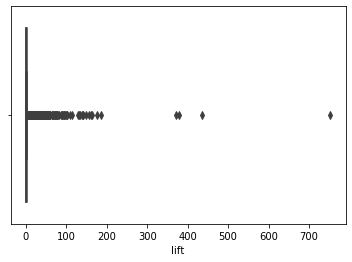

In [297]:
sns.boxplot(offer_impact.lift)
plt.show()

#will filter down the outliers to group medians

## Profile Dataset

In [10]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [11]:
#establish and test for %NA
profile.gender = profile.gender.replace({'None':np.nan})
profile.age=profile.age.replace({118:np.nan})
profile.isna().sum()/len(profile)*100


gender              12.794118
age                 12.794118
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [12]:
# convert became member on to datetime, then establish 'months since join'
profile.became_member_on = profile.became_member_on.apply(lambda x: pd.to_datetime(str(x),format = '%Y%m%d'))
profile['months_since_join']=profile.became_member_on.apply(lambda x: pd.Timedelta(pd.Timestamp.today()-x).days/30)

#enumerate the gender column
profile.gender=profile.gender.replace({'F':0, 'M':1, 'O':np.nan})
profile.gender = pd.to_numeric(profile.gender)
profile.head()

,gender,age,id,became_member_on,income,months_since_join
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,38.966667
1,0.0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,33.866667
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,21.800000
3,0.0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,36.100000
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,33.200000


In [13]:
#impute missing data using KNN Imputer
from sklearn.impute import KNNImputer
imp = KNNImputer()
profile_imp = pd.DataFrame(imp.fit_transform(profile[['gender','age','income','months_since_join']]), columns = ['gender','age','income','months_since_join'])

# Join person ID back onto imputed values
profile = pd.concat([profile_imp,profile.id],axis = 1)
# round gender value back to 1/0
profile.gender = round(profile.gender,0)
profile.head()


,gender,age,income,months_since_join,id
0,1.0,51.2,55200.0,38.966667,68be06ca386d4c31939f3a4f0e3dd783
1,0.0,55.0,112000.0,33.866667,0610b486422d4921ae7d2bf64640c50b
2,0.0,47.0,64200.0,21.800000,38fe809add3b4fcf9315a9694bb96ff5
3,0.0,75.0,100000.0,36.100000,78afa995795e4d85b5d9ceeca43f5fef
4,1.0,59.8,69000.0,33.200000,a03223e636434f42ac4c3df47e8bac43


In [14]:
# save pickle of profile
with open('data/profile.pickle', 'wb') as f:
    pickle.dump(profile, f)

In [24]:
# pd.to_pickle
offer_impact = pd.read_pickle('data/offer_impact.pickle')


In [25]:
# join person information and offer information to main table
offer_impact = offer_impact.merge(profile, how = 'inner',left_on='person',right_on= 'id')
offer_impact.drop(columns=['offer_daily_spend','person','id'], inplace = True)

offer_impact = offer_impact.merge(portfolio, how = 'inner',left_on='offer',right_on= 'id')
offer_impact.drop(columns=[,'offer','id'], inplace = True)

offer_impact.head()

,no_influence_avg_daily_spend,lift,gender,age,income,months_since_join,reward,difficulty,duration,mobile,email,social,web,discount,bogo,informational
0,4.002778,0.062684,0.0,50.0,65800.0,48.133333,5,5,5,1,1,1,1,0,1,0
1,9.197368,0.454659,0.0,68.0,74000.0,32.200000,5,5,5,1,1,1,1,0,1,0
2,4.226000,1.200899,0.0,63.0,81000.0,70.000000,5,5,5,1,1,1,1,0,1,0
3,1.129333,0.211250,1.0,70.0,32000.0,25.700000,5,5,5,1,1,1,1,0,1,0
4,0.671250,0.913718,1.0,23.0,41000.0,68.500000,5,5,5,1,1,1,1,0,1,0


In [31]:
# train pipeline and regression model to predict the 'lift' of a promotion on an individual's spending

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRFRegressor
from sklearn.pipeline import Pipeline

X = offer_impact.drop(columns='lift')
y = offer_impact.lift

random_state = 80

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def build_model ():
    print('Building model')
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('reg', XGBRFRegressor())
        ])

    parameters = {
        # 'estimator__reg__n_estimators': [50,100,200],
        # 'estimator__reg__max_depth': [3, 5]
        }

    return GridSearchCV(pipeline, param_grid=parameters,  cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')

model = build_model()

model.fit(X_train,y_train)



Building model
[15:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reg',
                                        XGBRFRegressor(base_score=0.5,
                                                       colsample_bylevel=1,
                                                       colsample_bynode=0.8,
                                                       colsample_bytree=1,
                                                       gamma=0, learning_rate=1,
                                                       max_delta_step=0,
                                                       max_depth=3,
                                                       min_child_weight=1,
                 